In [1]:
import os
import random
import string
import re
import requests
import gzip
import shutil
import json
import types
import datetime
import decimal
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt

endpoint = "http://10.119.9.178:9999/blazegraph/sparql"  # SPARQL endpoint hosting previous version of ITO.owl
prefixes = """
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix ito: <https://identifiers.org/ito:>
prefix edam: <http://edamontology.org/>
prefix obo: <http://www.geneontology.org/formats/oboInOwl#>
prefix dc: <http://purl.org/dc/elements/1.1/>
"""


def query(query, return_format = JSON):
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(return_format)
    sparql.setQuery(prefixes + query)
    results = sparql.query().convert()
    return results


def query_df(query, numeric_cols = []):
    # Run SPARQL query, and convert results to Pandas dataframe
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(JSON)
    sparql.setQuery(prefixes + query)
    results = sparql.query()
    processed_results = json.load(results.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df

def tasks_stat_dict(df):
    from collections import defaultdict
    tasks_stat = defaultdict(int)
    for idx, row in df.iterrows():
        for task in row["tasks"]:
            tasks_stat[task] += 1
    return dict(sorted(tasks_stat.items(), key=lambda x: x[1], reverse=True))
    

In [2]:
filename = './datasets.json.gz'
if not os.path.exists(filename):
    url = 'https://paperswithcode.com/media/about/datasets.json.gz'
    myfile = requests.get(url)
    with open(filename, 'wb') as o:
        o.write(myfile.content)
    with gzip.open(filename, 'rb') as f_in:
        with open('./datasets.json', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

with open('datasets.json') as f:
    datasets_ = json.load(f)
    
variant_to_parent = dict()
variant_to_url = dict()
# unprioritize independency
for dataset in datasets_:
    variant_to_parent[dataset["name"]] = dataset["name"]
    variant_to_url[dataset["name"]] = dataset["url"]
for dataset in datasets_:
    ## create variant_to_parent mapping 
    for variant in dataset["variants"]:
        if dataset["name"] != variant:
            variant_to_parent[variant] = dataset["name"]
            variant_to_url[dataset["name"]] = dataset["url"]

Description whole df
       n_entries    n_tasks
count  91.000000  91.000000
mean    6.384615   1.395604
std     6.910168   0.828374
min     1.000000   1.000000
25%     2.000000   1.000000
50%     4.000000   1.000000
75%     8.000000   1.000000
max    47.000000   5.000000
Length popular 26
Length unpopular 24


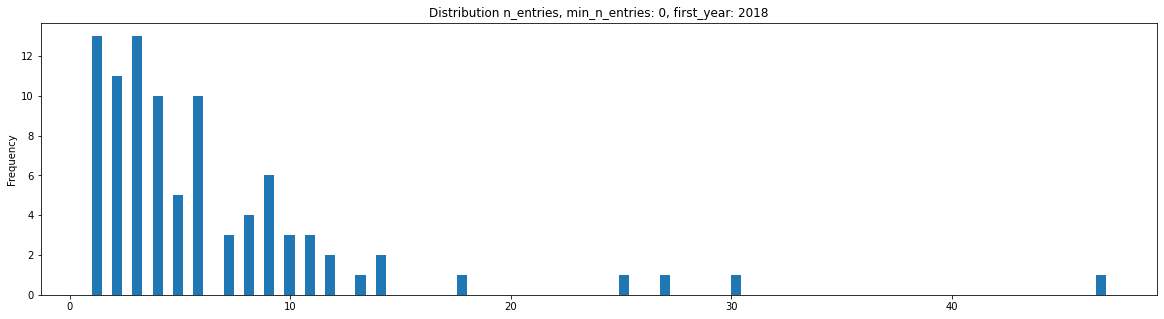

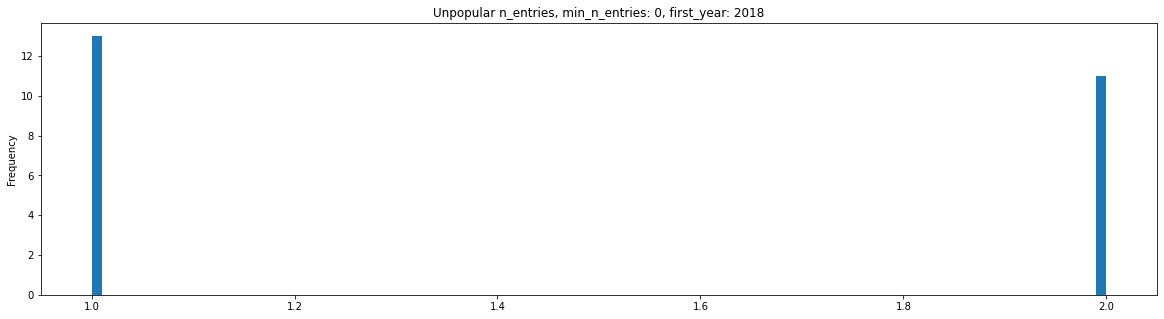

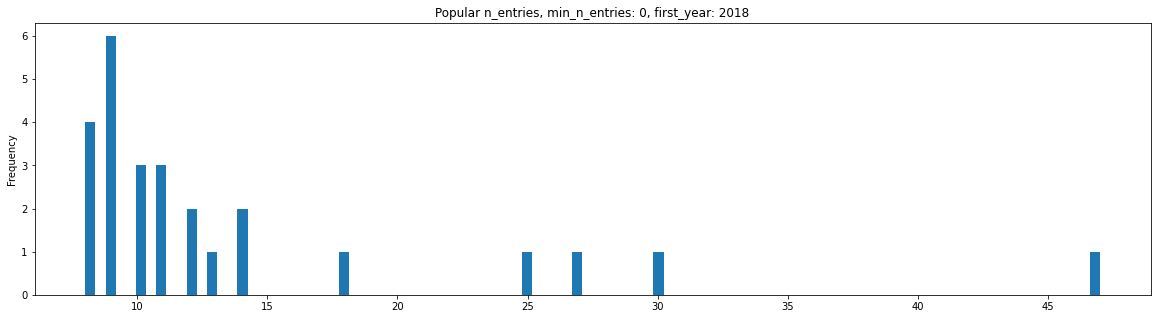

In [3]:
first_year = 2018
min_n_entries = 0
prefix="cv"
root = "https://identifiers.org/ito:ITO_00101"

df = query_df("""
SELECT * WHERE {
    ?benchmark rdfs:subClassOf+ <""" + root + """> .
    ?benchmark rdfs:subClassOf <https://identifiers.org/ito:Benchmarking> .
    ?benchmark rdfs:label ?benchmark_label .
    ?result rdf:type ?benchmark .
    OPTIONAL {?result obo:date ?date .}
}
""")
df["benchmark_label"] = df["benchmark_label"].str.replace(" benchmarking", "")
df[["benchmark_label", "task_label"]] = df["benchmark_label"].str.split(' - ', 1, expand=True)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by="date")

df["benchmark_label"] = df["benchmark_label"].apply(lambda x: variant_to_parent.get(x, None))
df = df.dropna(subset=["benchmark_label"])

def agg(examples):
    examples = examples.sort_values(by="date")
    return pd.Series({"first_date": examples.iloc[0]["date"], "n_entries": len(examples), "n_tasks": len(set(examples["task_label"])), "tasks": set(examples["task_label"])})

df = df.groupby(["benchmark_label"])[["result", "date", "task_label"]].apply(agg).reset_index()
df["url"] = df["benchmark_label"].apply(lambda x: variant_to_url.get(x, None))
df = df.sort_values(by="n_entries", ascending=False)

df.to_csv(f"{prefix}_all_unfiltered.csv", index=None)

# filter year
if first_year > -1:
    df = df[df['first_date'].dt.year == first_year]

# filter n_entries
df = df[df.n_entries >= min_n_entries]

description = df.describe()
print("Description whole df")
print(description)

plt.figure();
df["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Distribution n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

unpopular = df[df.n_entries <= float(description["n_entries"].loc["25%"])]
popular = df[df.n_entries >= float(description["n_entries"].loc["75%"])]

popular.to_csv(f"{prefix}_popular.csv", index=None)
unpopular.to_csv(f"{prefix}_unpopular.csv", index=None)

print(f"Length popular {len(popular)}")
print(f"Length unpopular {len(unpopular)}")

plt.figure();
unpopular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Unpopular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");
plt.figure();
popular["n_entries"].plot.hist(stacked=True, bins=100, figsize=(20,5), title=f"Popular n_entries, min_n_entries: {min_n_entries}, first_year: {first_year}");

In [4]:
popular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
502,RefCOCO,2018-01-24,47,1,{Referring Expression Segmentation},https://paperswithcode.com/dataset/refcoco
441,Oxford-IIIT Pets,2018-05-24,30,3,"{Image Classification, Fine-Grained Image Clas...",https://paperswithcode.com/dataset/oxford-iiit...
299,ImageNet-C,2018-11-29,27,2,"{Unsupervised Domain Adaptation, Domain Genera...",https://paperswithcode.com/dataset/imagenet-c
215,FC100,2018-05-23,25,1,{Few-Shot Image Classification},https://paperswithcode.com/dataset/fc100
564,SoccerNet-v2,2018-04-12,18,4,"{Camera shot segmentation, Camera shot boundar...",https://paperswithcode.com/dataset/soccernet-v2
282,ICDAR 2017,2018-01-05,14,1,{Scene Text Detection},https://paperswithcode.com/dataset/icdar-2017
519,SHREC,2018-01-21,14,4,"{Hand Gesture Recognition, 3D Object Recogniti...",https://paperswithcode.com/dataset/shrec
200,ETH,2018-03-29,13,1,{Trajectory Prediction},https://paperswithcode.com/dataset/eth
651,VehicleID,2018-11-13,12,1,{Vehicle Re-Identification},https://paperswithcode.com/dataset/vehicleid
240,Foggy Cityscapes,2018-03-08,12,3,"{Weakly Supervised Object Detection, Image-to-...",https://paperswithcode.com/dataset/foggy-citys...


In [5]:
popular.describe()

,n_entries,n_tasks
count,26.000000,26.000000
mean,13.884615,1.769231
std,9.008116,1.106623
min,8.000000,1.000000
25%,9.000000,1.000000
50%,10.500000,1.000000
75%,13.750000,2.750000
max,47.000000,4.000000


In [6]:
tasks_stat_dict(popular)

{'Image Classification': 2,
 'Fine-Grained Image Classification': 2,
 'Unsupervised Domain Adaptation': 2,
 'Image Denoising': 2,
 'Lipreading': 2,
 'Referring Expression Segmentation': 1,
 'Image Compression': 1,
 'Domain Generalization': 1,
 'Few-Shot Image Classification': 1,
 'Camera shot segmentation': 1,
 'Camera shot boundary detection': 1,
 'Replay Grounding': 1,
 'Action Spotting': 1,
 'Scene Text Detection': 1,
 'Hand Gesture Recognition': 1,
 '3D Object Recognition': 1,
 'Point Cloud Super Resolution': 1,
 'Skeleton Based Action Recognition': 1,
 'Trajectory Prediction': 1,
 'Vehicle Re-Identification': 1,
 'Weakly Supervised Object Detection': 1,
 'Image-to-Image Translation': 1,
 'Panoptic Segmentation': 1,
 'Semantic Segmentation': 1,
 'Visual Place Recognition': 1,
 'Human-Object Interaction Detection': 1,
 'Unconstrained Lip-synchronization': 1,
 'Visual Question Answering': 1,
 'Image Dehazing': 1,
 'Text based Person Retrieval': 1,
 'Object Detection': 1,
 'Semantic c

In [7]:
unpopular.iloc[0:30]

,benchmark_label,first_date,n_entries,n_tasks,tasks,url
560,Sim10k,2018-12-12,2,1,{Unsupervised Domain Adaptation},https://paperswithcode.com/dataset/sim10k
620,UFPR-ALPR,2018-02-26,2,1,{License Plate Recognition},https://paperswithcode.com/dataset/ufpr-alpr
144,Cluttered Omniglot,2018-03-26,2,1,{One-Shot Segmentation},https://paperswithcode.com/dataset/cluttered-o...
148,Color FERET,2018-10-26,2,1,{Face Recognition},https://paperswithcode.com/dataset/color-feret
149,Comic2k,2018-03-30,2,1,{Weakly Supervised Object Detection},https://paperswithcode.com/dataset/comic2k
294,IconArt,2018-10-05,2,1,{Weakly Supervised Object Detection},https://paperswithcode.com/dataset/iconart
382,Make3D,2018-06-04,2,1,{Monocular Depth Estimation},https://paperswithcode.com/dataset/make3d
376,MSRC-12,2018-11-17,2,2,"{Gesture Recognition, Skeleton Based Action Re...",https://paperswithcode.com/dataset/msrc-12
340,Letter,2018-12-11,2,1,{Image Clustering},https://paperswithcode.com/dataset/letter
529,SSIG-SegPlate,2018-02-26,2,1,{License Plate Recognition},https://paperswithcode.com/dataset/ssig-segplate


In [8]:
unpopular.describe()

,n_entries,n_tasks
count,24.000000,24.000000
mean,1.458333,1.041667
std,0.508977,0.204124
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,2.000000,2.000000


In [9]:
tasks_stat_dict(unpopular)

{'License Plate Recognition': 2,
 'Weakly Supervised Object Detection': 2,
 'Steering Control': 2,
 'Unsupervised Domain Adaptation': 1,
 'One-Shot Segmentation': 1,
 'Face Recognition': 1,
 'Monocular Depth Estimation': 1,
 'Gesture Recognition': 1,
 'Skeleton Based Action Recognition': 1,
 'Image Clustering': 1,
 'Object Skeleton Detection': 1,
 '3D Face Animation': 1,
 'Human Instance Segmentation': 1,
 'Object Localization': 1,
 'Trajectory Prediction': 1,
 'Unseen Object Instance Segmentation': 1,
 'Domain Adaptation': 1,
 'Retinal Vessel Segmentation': 1,
 'Gaze Estimation': 1,
 'Motion Segmentation': 1,
 'Visual Question Answering': 1,
 '2D Object Detection': 1}